In [1]:
from typing import List
import torch
from PIL import Image
from pipeline_sd import MagnetSDPipeline
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from utils.magnet_utils import *
from utils.vis_utils import *
from utils.ptp_utils import *
from pytorch_lightning import seed_everything
from torch.nn import functional as F

/home/hy/anaconda3/envs/magnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable_diffusion_version = "path-to-stable-diffusion-v1-4"
stable = MagnetSDPipeline.from_pretrained(stable_diffusion_version).to(device)
stable.prepare_candidates("./bank/candidates_1_4.pt")

tokenizer = stable.tokenizer
text_encoder = stable.text_encoder.eval()
NUM_DDIM_STEPS = 50

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/home/hy/anaconda3/envs/magnet/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]
2024-09-23 10:50:25 WARNING: Language en package default expects mwt, which has been added
2024-09-23 10:50:25 INFO: Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| mwt          | combined            |
| pos          | combined_charlm     |
| constituency | ptb3-revised_charlm |

2024-09-23 10:50:25 INFO: Using device: cud

Finished loading candidate embeddings with shape: torch.Size([614, 768])


In [3]:
controller = AttentionStore()
register_attention_control_for_image(stable, controller)

In [4]:
def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool):
    out = []
    attention_maps = attention_store.attention_store
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(1, -1, res, res, item.shape[-1])[0]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(prompt, tokenizer, attention_store: AttentionStore, res: int, from_where: List[str], show_tokens_index=None):
    tokens = tokenizer.encode(prompt)
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where=from_where, is_cross=True)
    images = []
    if show_tokens_index is not None:
        token_range = show_tokens_index
    else:
        token_range = range(len(tokens))
    for i in token_range:
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.detach().cpu().numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        if i > len(tokens) - 1:
            image = text_under_image(image, '<|pad|>')
        else:
            image = text_under_image(image, decoder(int(tokens[i])), font=cv2.FONT_ITALIC)
        images.append(image)
    view_images(np.stack(images, axis=0))

### Attribute Entanglement Examples

Global seed set to 268
100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


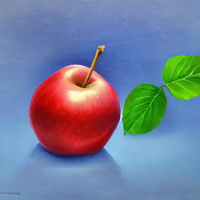

In [9]:
stable.magnet_embeddings = None
prompt = "blue apple"
cur_seed = 268
seed_everything(cur_seed)
controller.reset()
outputs = stable(
    prompt=prompt,
    guidance_scale=7.5,
    num_inference_steps=50,
    num_images_per_prompt=1
).images
outputs[0].resize((200, 200))

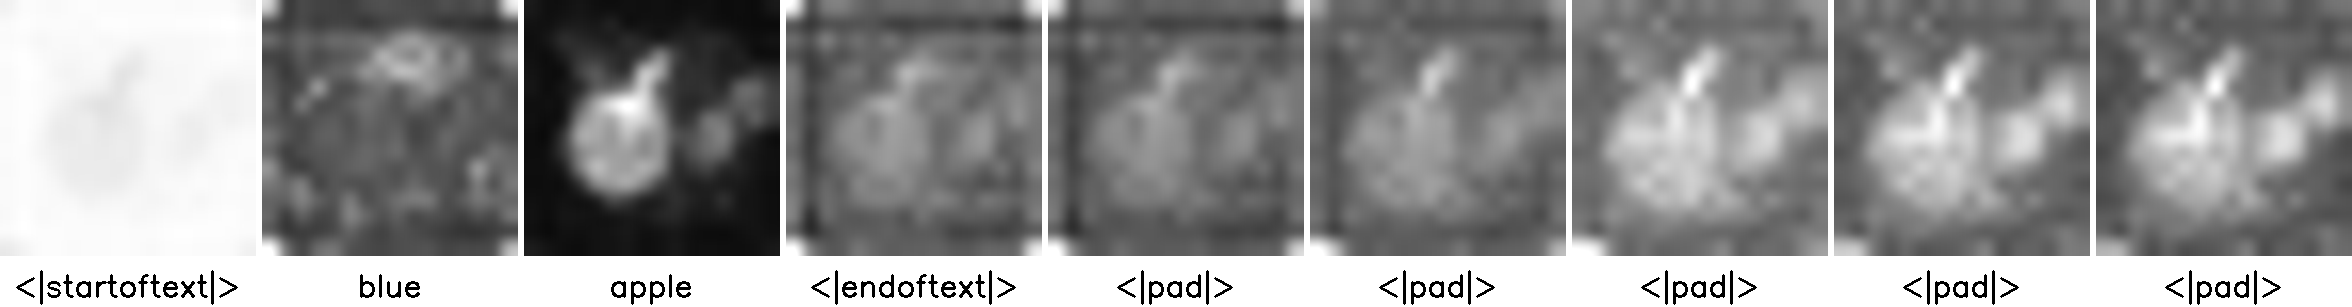

In [11]:
# Activations of "apple" align with padding embeddings instead of those of target attribute "blue".
# Consider later padding embeddings have lost the context of target color "blue".
# In this case, the image colored "red" is the one preferred by the prior knowledge.
promtids = tokenizer.encode(prompt)
show_cross_attention(prompt, stable.tokenizer, controller, 16, ('up', 'down', 'mid'), show_tokens_index=[0, 1, 2, 3, 4, 20, 40, 60, 76])

Global seed set to 78
100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


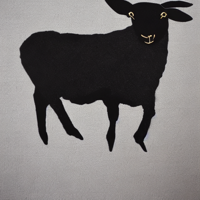

In [35]:
prompt = "black sheep"
cur_seed = 78
seed_everything(cur_seed)
controller.reset()
outputs = stable(
    prompt=prompt,
    guidance_scale=7.5,
    num_inference_steps=50,
    num_images_per_prompt=1
).images
outputs[0].resize((200, 200))

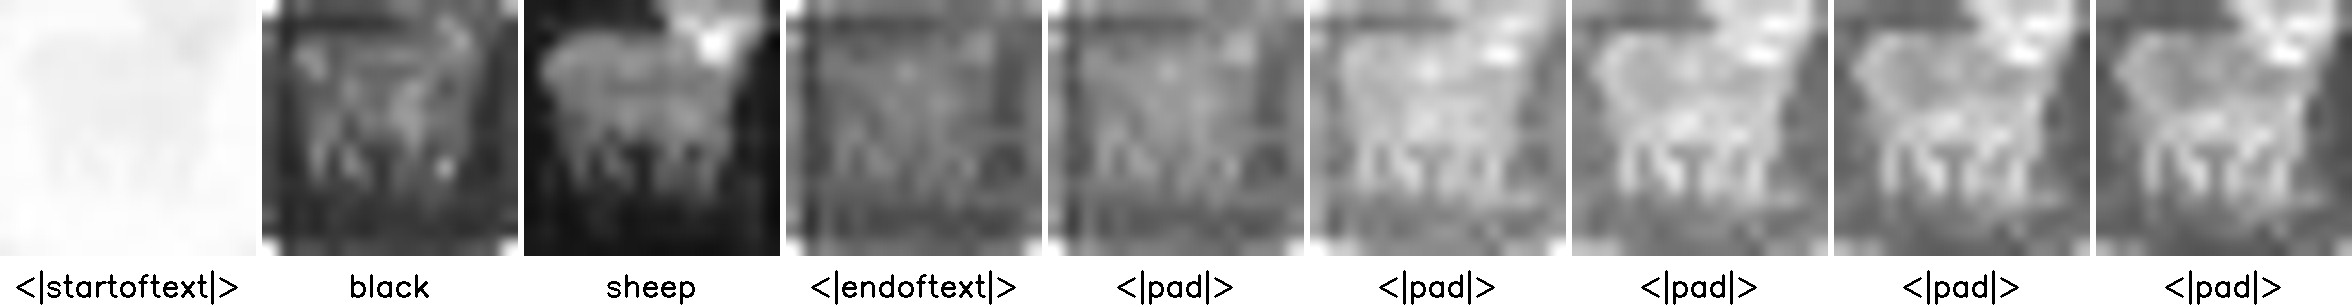

In [36]:
# Unnatural attribute "black" s.t. object "sheep".
# The context issue in padding embeddings leads to out-of-distribution result (painting-like).
promtids = tokenizer.encode(prompt)
show_cross_attention(prompt, stable.tokenizer, controller, 16, ('up', 'down', 'mid'), show_tokens_index=[0, 1, 2, 3, 4, 20, 40, 60, 76])

### Multi-Concept Entanglement Examples

Global seed set to 170
/home/hy/anaconda3/envs/magnet/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:237: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


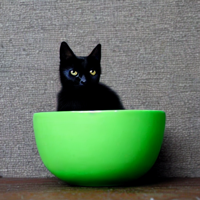

In [14]:
prompt = "a black cat on a green bowl"
cur_seed = 170
seed_everything(cur_seed)
controller.reset()
outputs = stable(
    prompt=prompt,
    guidance_scale=7.5,
    num_inference_steps=50,
    num_images_per_prompt=1
).images
outputs[0].resize((200, 200))

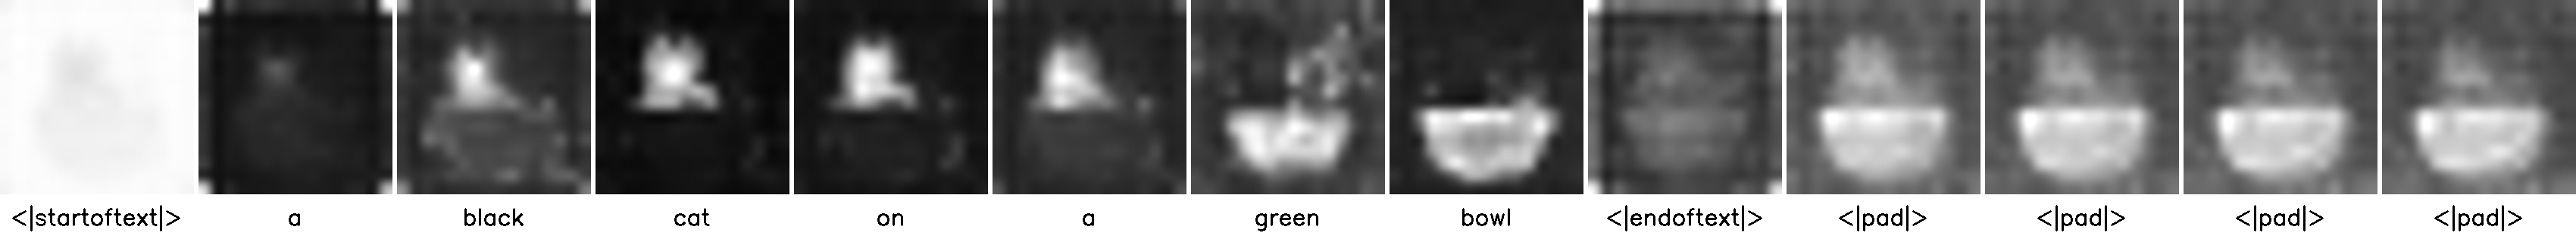

In [17]:
# Visualization shows that padding embeddings have entangled two concepts.
# In this case we use two natural concept, so we get passable result.
promtids = tokenizer.encode(prompt)
show_cross_attention(prompt, stable.tokenizer, controller, 16, ('up', 'down', 'mid'), show_tokens_index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 20, 40, 60, 76])

Global seed set to 1610
/home/hy/anaconda3/envs/magnet/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:237: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


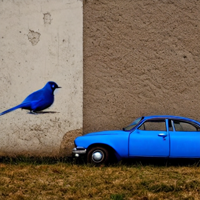

In [18]:
prompt = "a blue bird and a brown car"
cur_seed = 1610
seed_everything(cur_seed)
controller.reset()
outputs = stable(
    prompt=prompt,
    guidance_scale=7.5,
    num_inference_steps=50,
    num_images_per_prompt=1
).images
outputs[0].resize((200, 200))

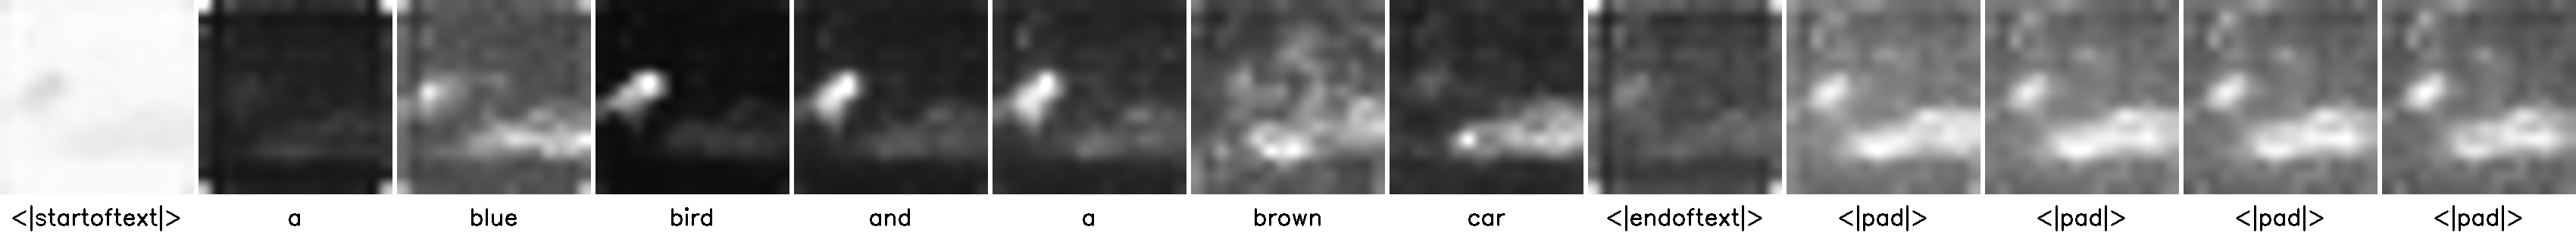

In [19]:
# Visualization shows that padding embeddings have entangled two concepts.
# Entanglement in padding embeddings leads to activation overlap between "bird" and "car".
# In this case, both objects attract attribute "blue", but neglect "brown", i.e., attribute leakage issue.
promtids = tokenizer.encode(prompt)
show_cross_attention(prompt, stable.tokenizer, controller, 16, ('up', 'down', 'mid'), show_tokens_index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 20, 40, 60, 76])

Global seed set to 7705
/home/hy/anaconda3/envs/magnet/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:237: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


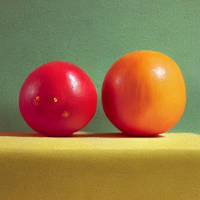

In [20]:
prompt = "a red lemon and a yellow tomato"
cur_seed = 7705
seed_everything(cur_seed)
controller.reset()
outputs = stable(
    prompt=prompt,
    guidance_scale=7.5,
    num_inference_steps=50,
    num_images_per_prompt=1
).images
outputs[0].resize((200, 200))

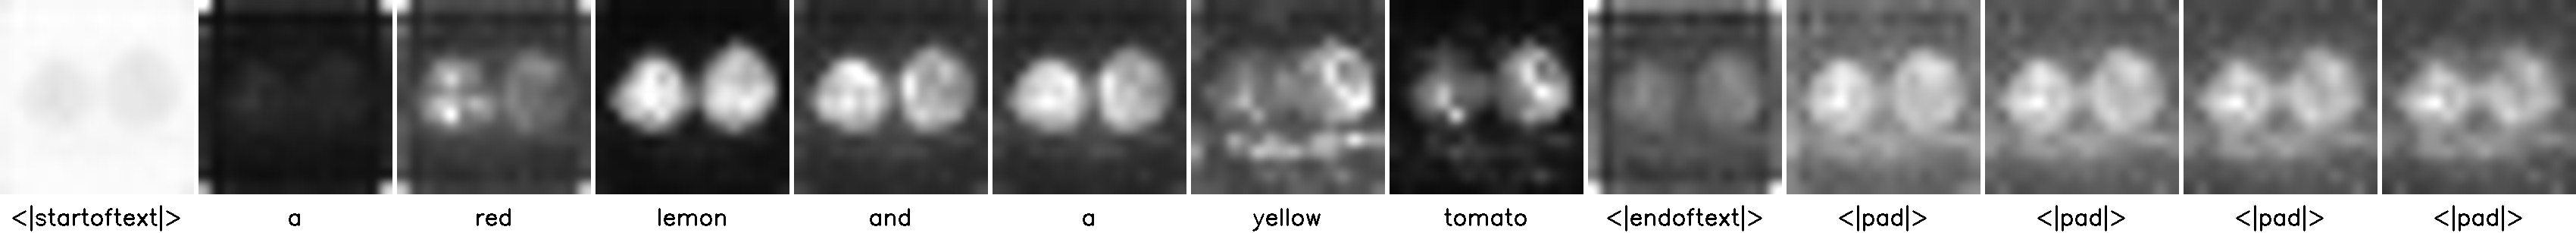

In [21]:
# Visualization shows that padding embeddings have entangled two concepts.
# Entanglement in padding embeddings leads to "lemon" and "tomato" indistinguishable.
# In this case, objects in the resulting image have ambiguous features, i.e., stick issue.
promtids = tokenizer.encode(prompt)
show_cross_attention(prompt, stable.tokenizer, controller, 16, ('up', 'down', 'mid'), show_tokens_index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 20, 40, 60, 76])

### Magnet Example: anti-prior ability by enhancing disentanglement

Global seed set to 2576
/home/hy/anaconda3/envs/magnet/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:237: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


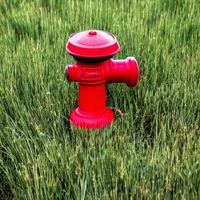

In [5]:
prompt = "A green fire hydrant sitting on a patch of red grass"

stable.magnet_embeddings = None
cur_seed = 2576
seed_everything(cur_seed)

controller.reset()

outputs = stable(
    prompt=prompt,
    guidance_scale=7.5,
    num_inference_steps=50,
    num_images_per_prompt=1
).images
outputs[0].resize((200, 200))

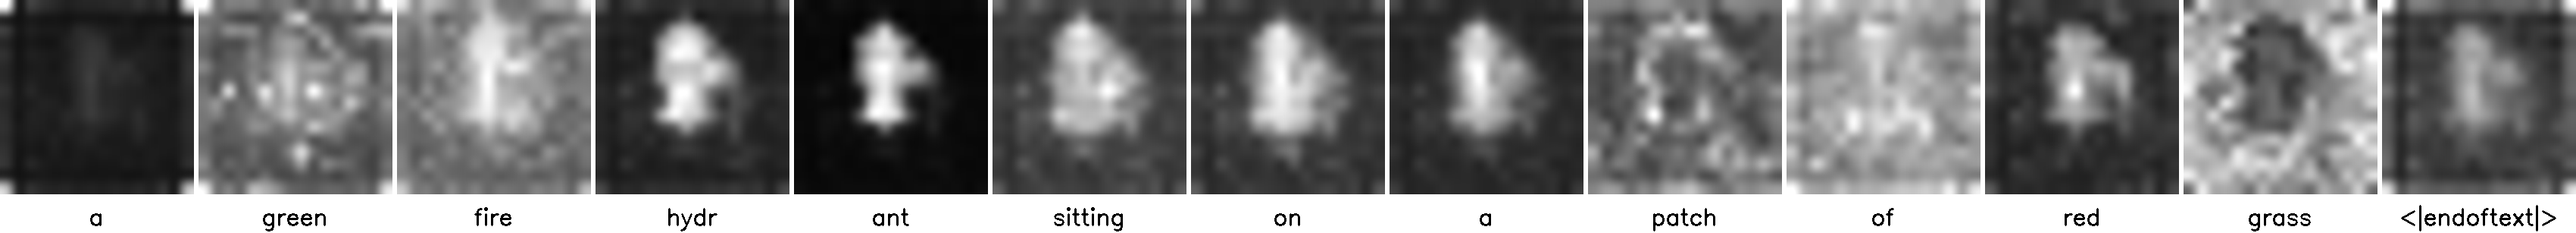

In [6]:
promtids = tokenizer.encode(prompt)
show_cross_attention(prompt, stable.tokenizer, controller, 16, ('up', 'down', 'mid'), show_tokens_index=range(1, len(promtids)))

Global seed set to 2576
100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


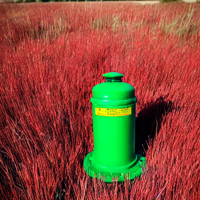

In [7]:
alpha_lambda = 0.6
K = 5
stable.get_magnet_direction(
    prompt, 
    alpha_lambda=alpha_lambda, 
    K=K,
    neighbor="feature", 
    use_neg=True,
    use_pos=True
)

seed_everything(cur_seed)

controller.reset()

outputs = stable(
    prompt=prompt,
    guidance_scale=7.5,
    num_inference_steps=50,
    num_images_per_prompt=1
).images
outputs[0].resize((200, 200))

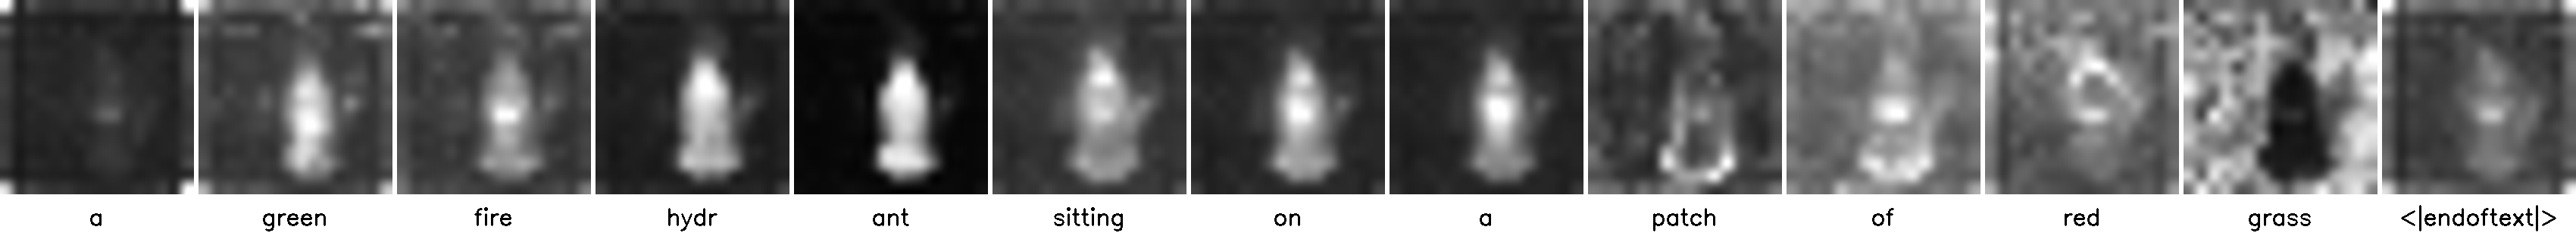

In [8]:
show_cross_attention(prompt, stable.tokenizer, controller, 16, ('up', 'down', 'mid'), show_tokens_index=range(1, len(promtids)))